# Incremental Factorization Machines

In [3]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [4]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [5]:
exp_click = Runner(dataset='click', params={})

[48345] [exp] click | window_size = 5000, n_epoch = 1
[48345] [exp] n_sample = 3570; 714 (20%) + 357 (10%) + 2499 (70%)
[48345] [exp] n_user = 3570, n_item = 5


In [6]:
exp_ML1M = Runner(dataset='ML1M', params={})

[48345] [exp] ML1M | window_size = 5000, n_epoch = 1
[48345] [exp] n_sample = 226310; 45262 (20%) + 22631 (10%) + 158417 (70%)
[48345] [exp] n_user = 6014, n_item = 3232


In [7]:
exp_ML100k = Runner(dataset='ML100k', params={})

[48345] [exp] ML100k | window_size = 5000, n_epoch = 1
[48345] [exp] n_sample = 21201; 4240 (20%) + 2120 (10%) + 14841 (70%)
[48345] [exp] n_user = 928, n_item = 1172


In [8]:
exp_lastfm = Runner(dataset='LastFM', params={})

[48345] [exp] LastFM | window_size = 5000, n_epoch = 1
[48345] [exp] n_sample = 159798; 31959 (20%) + 15979 (10%) + 111860 (70%)
[48345] [exp] n_user = 92, n_item = 51072


### Plot-related preparation

In [9]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

# colors[14], colors[0], colors[4], colors[2], colors[6]

In [100]:
def read_result(dirname, dataset, method, T, n_trial):
    t_reco = t_update = 0.
    recalls = []
    
    if type(n_trial) == str:  # read a specific trial
        path = dirname + '/' + '_'.join([dataset, method, T, n_trial]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            recalls = lines[2:]
        return recalls 
    
    for trial in range(1, n_trial + 1):
        path = dirname + '/' + '_'.join([dataset, method, T, str(trial)]) + '.txt'
        with open(path) as f:
            lines = list(map(lambda l: float(l.rstrip()), f.readlines()))
            t_reco += lines[0]
            t_update += lines[1]
            recalls.append(lines[2:])
            
    return {'t_reco': t_reco / n_trial, 't_update': t_update / n_trial, 'recalls': recalls}

In [11]:
def show_results(MF, iMF, FMs, iFMs):
    print('static MF')
    print('=========')
    print('avg. reco time      = %.5f' % MF['t_reco'])
    print('avg. update time    = ---') 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(MF['recalls']), np.std(MF['recalls'])))
    print()
    
    print('iMF')
    print('===')
    print('avg. reco time      = %.5f' % iMF['t_reco'])
    print('avg. update time    = %.5f' % iMF['t_update']) 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iMF['recalls']), np.std(iMF['recalls'])))
    print()
    
    print('static FMs')
    print('==========')
    print('avg. reco time      = %.5f' % FMs['t_reco'])
    print('avg. update time    = ---') 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(FMs['recalls']), np.std(FMs['recalls'])))
    print()
    
    print('iFMs')
    print('====')
    print('avg. reco time      = %.5f' % iFMs['t_reco'])
    print('avg. update time    = %.5f' % iFMs['t_update']) 
    print('recall: mean (±std) = %.3f (±%.3f)' % (np.mean(iFMs['recalls']), np.std(iFMs['recalls'])))
    print()

In [12]:
def plot(name, exp, MF, iMF, FMs, iFMs, N=10, T=5000):

    # plot incremental recall
    offset = exp.data.n_batch_train + exp.data.n_batch_test
    x = np.arange(exp.data.n_sample - offset) + offset

    every = int(exp.data.n_test / 8)

    best = np.argsort([sum(l) for l in MF['recalls']])[-1]
    plt.plot(x, MF['recalls'][best], c=colors[4], label='static MF', ms=8., mfc='none', marker='s', mew=1.2, mec=colors[4], markevery=(int(every/2), every))

    best = np.argsort([sum(l) for l in iMF['recalls']])[-1]
    plt.plot(x, iMF['recalls'][best], c=colors[0], label='iMF', ms=8., marker='s', mew=0, markevery=every)
    
    best = np.argsort([sum(l) for l in FMs['recalls']])[-1]
    plt.plot(x, FMs['recalls'][best], c=colors[2], label='static FMs', ms=10., mfc='none', marker='^', mew=1.2, mec=colors[2], markevery=(int(every/2), every))
    
    best = np.argsort([sum(l) for l in iFMs['recalls']])[-1]
    plt.plot(x, iFMs['recalls'][best], c=colors[6], label='iFMs', marker='^', ms=10., mew=0, markevery=every)
    
    plt.xlabel(r'old $\leftarrow$ sample index $\rightarrow$ new', fontsize=11)
    plt.ylabel('recall@N / T', fontsize=11)
    
    ax = plt.gca()
    ax.yaxis.grid(True)
    ax.patch.set_visible(False)
    
    plt.yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
    plt.ylim([0.0, 0.15])
     
    # head-of-evaluate | first T samples (1st window)
    ax.axvline(x=(offset - 1 + T - 1), linewidth=1, linestyle=':', color=colors[14])
    
    fig = plt.gcf()
    fig.set_size_inches((5.5, 3))
    fig.patch.set_alpha(0.0)
    
    plt.title('%s (N = %d, T = %d)' % (name, N, T), fontweight='bold')
    plt.xlim((0, exp.data.n_sample - 1))
    
    plt.tight_layout()

## Synthetic Click

In [142]:
## k=2, reg_w0=2., reg_w=8., reg_V=16., lr=0.001, epoch=1
click_staticFMs = read_result('results/recprofile/click', 'click', 'static-FMs', '500', 5)
click_iFMs = read_result('results/recprofile/click', 'click', 'iFMs', '500', 5)

## k=2, reg=0.01, lr=0.001, epoch=100
click_staticMF = read_result('results/recprofile/click', 'click', 'static-MF', '500', 5)
click_iMF = read_result('results/recprofile/click', 'click', 'iMF', '500', 5)

static MF
avg. reco time      = 0.00003
avg. update time    = ---
recall: mean (±std) = 0.195 (±0.105)

iMF
===
avg. reco time      = 0.00002
avg. update time    = 0.00002
recall: mean (±std) = 0.207 (±0.098)

static FMs
avg. reco time      = 0.00284
avg. update time    = ---
recall: mean (±std) = 0.257 (±0.122)

iFMs
====
avg. reco time      = 0.00290
avg. update time    = 0.00024
recall: mean (±std) = 0.276 (±0.148)



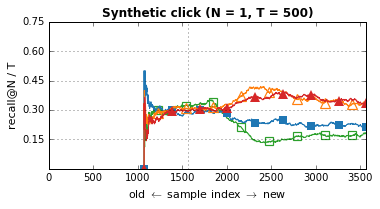

In [143]:
plot('Synthetic click', exp_click, click_staticMF, click_iMF, click_staticFMs, click_iFMs, N=1, T=500)
plt.yticks([.15, .30, .45, .60, .75])
plt.ylim([0.0, .75])

show_results(click_staticMF, click_iMF, click_staticFMs, click_iFMs)

### MovieLens

In [14]:
max_dt = exp_ML1M.data.dts[-1]
max_dt

1038

In [15]:
hist_u1 = np.zeros(max_dt + 1)
hist_u2 = np.zeros(max_dt + 1)
hist_u3 = np.zeros(max_dt + 1)

for i, d in enumerate(exp_ML1M.data.samples):
    dt = exp_ML1M.data.dts[i]
    if d['u_index'] == 32:
        hist_u1[dt] += 1
    elif d['u_index'] == 2016:
        hist_u2[dt] += 1
    elif d['u_index'] == 6008:
        hist_u3[dt] += 1

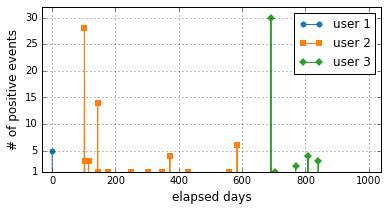

In [19]:
fig, ax = plt.subplots()

ax.set_xlim([-32, max_dt + 1])
ax.grid(True)

x = np.arange(max_dt + 1)

ax.plot(x, hist_u1, label='user 1', color=colors[0], lw=1., marker='o', mew=0.)
ax.plot(x, hist_u2, label='user 2', color=colors[2], lw=1., marker='s', mew=0.)
ax.plot(x, hist_u3, label='user 3', color=colors[4], lw=1., marker='D', mew=0.)

ax.set_xlabel('elapsed days')
ax.set_ylabel('# of positive events')
ax.legend(loc='upper right').get_frame().set_facecolor('white')

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)

ax.set_yticks([1, 5, 10, 15, 20, 25, 30])
ax.set_ylim([1., 32])

plt.tight_layout()
fig.savefig('../../paper/images/recprofile/ml-user-activity.eps')

### ML100k

$T=3000$

In [147]:
## k=40, reg_w0=2., reg_w=8., reg_V=16., lr=0.004, epoch=3
ML100k_staticFMs = read_result('results/recprofile/ML100k', 'ML100k', 'static-FMs', '3000', 5)
ML100k_iFMs = read_result('results/recprofile/ML100k', 'ML100k', 'iFMs', '3000', 5)

## k=40, reg=0.01, lr=0.003, epoch=20
ML100k_staticMF = read_result('results/recprofile/ML100k', 'ML100k', 'static-MF', '3000', 5)
ML100k_iMF = read_result('results/recprofile/ML100k', 'ML100k', 'iMF', '3000', 5)

static MF
avg. reco time      = 0.00015
avg. update time    = ---
recall: mean (±std) = 0.020 (±0.004)

iMF
===
avg. reco time      = 0.00017
avg. update time    = 0.00003
recall: mean (±std) = 0.029 (±0.009)

static FMs
avg. reco time      = 0.02530
avg. update time    = ---
recall: mean (±std) = 0.021 (±0.008)

iFMs
====
avg. reco time      = 0.02687
avg. update time    = 0.00164
recall: mean (±std) = 0.034 (±0.008)



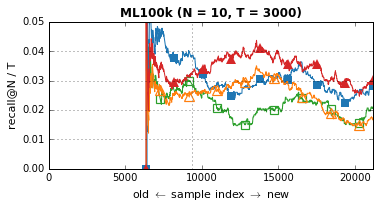

In [177]:
plot('ML100k', exp_ML100k, ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, N=10, T=3000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

show_results(ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs)

### ML1M

$T=9000$

In [160]:
## k=40, reg_w0=2., reg_w=8., reg_V=16., lr=0.004, epoch=2
ML1M_staticFMs = read_result('results', 'ML1M', 'iFMs', '9000', 1)
ML1M_iFMs = read_result('results', 'ML1M', 'iFMs', '9000', 1)

## k=40, reg=0.01, lr=0.003, epoch=10
ML1M_staticMF = read_result('results/recprofile/ML1M', 'ML1M', 'static-MF', '9000', 1)
ML1M_iMF = read_result('results/recprofile/ML1M', 'ML1M', 'iMF', '9000', 1)

static MF
avg. reco time      = 0.00073
avg. update time    = ---
recall: mean (±std) = 0.015 (±0.003)

iMF
===
avg. reco time      = 0.00071
avg. update time    = 0.00004
recall: mean (±std) = 0.034 (±0.004)

static FMs
avg. reco time      = 0.28994
avg. update time    = ---
recall: mean (±std) = 0.014 (±0.003)

iFMs
====
avg. reco time      = 0.28994
avg. update time    = 0.00594
recall: mean (±std) = 0.014 (±0.003)



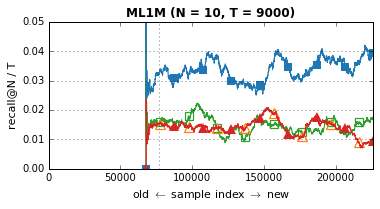

In [178]:
plot('ML1M', exp_ML1M, ML1M_staticMF, ML1M_iMF, ML1M_staticFMs, ML1M_iFMs, N=10, T=9000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

show_results(ML1M_staticMF, ML1M_iMF, ML1M_staticFMs, ML1M_iFMs)

## LastFM

In [24]:
max_dt = exp_lastfm.data.dts[-1]
max_dt

89

In [25]:
hist_i1 = np.zeros(max_dt + 1)
hist_i2 = np.zeros(max_dt + 1)
hist_i3 = np.zeros(max_dt + 1)

for i, d in enumerate(exp_lastfm.data.samples):
    dt = exp_lastfm.data.dts[i]
    if d['i_index'] == 3092:
        hist_i1[dt] += 1
    elif d['i_index'] == 23142:
        hist_i2[dt] += 1
    elif d['i_index'] == 44517:
        hist_i3[dt] += 1

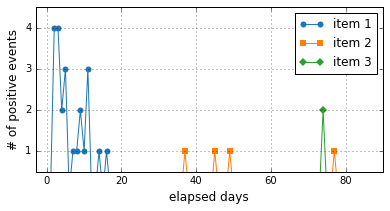

In [26]:
fig, ax = plt.subplots()

ax.set_xlim([-3, max_dt + 1])
ax.grid(True)

x = np.arange(max_dt + 1)

ax.plot(x, hist_i1, label='item 1', color=colors[0], lw=1., marker='o', mew=0.)
ax.plot(x, hist_i2, label='item 2', color=colors[2], lw=1., marker='s', mew=0.)
ax.plot(x, hist_i3, label='item 3', color=colors[4], lw=1., marker='D', mew=0.)

ax.set_xlabel('elapsed days')
ax.set_ylabel('# of positive events')
ax.legend(loc='upper right').get_frame().set_facecolor('white')

fig.set_size_inches((5.5, 3))
fig.patch.set_alpha(0.0)

ax.set_yticks([1, 2, 3, 4])
ax.set_ylim([.5, 4.5])

plt.tight_layout()
fig.savefig('../../paper/images/recprofile/lastfm-item.eps')

In [162]:
## k=40, reg_w0=2., reg_w=8., reg_V=16., lr=0.004, epoch=2
lastfm_staticFMs = read_result('results/recprofile/LastFM', 'LastFM', 'static-MF', '6000', 1)
lastfm_iFMs = read_result('results/recprofile/LastFM', 'LastFM', 'iMF', '6000', 1)

## k=20, reg=0.01, lr=0.03, epoch=15
lastfm_staticMF = read_result('results/recprofile/LastFM', 'LastFM', 'static-MF', '6000', 1)
lastfm_iMF = read_result('results/recprofile/LastFM', 'LastFM', 'iMF', '6000', 1)

static MF
avg. reco time      = 0.00708
avg. update time    = ---
recall: mean (±std) = 0.122 (±0.041)

iMF
===
avg. reco time      = 0.00704
avg. update time    = 0.00004
recall: mean (±std) = 0.059 (±0.030)

static FMs
avg. reco time      = 0.00708
avg. update time    = ---
recall: mean (±std) = 0.122 (±0.041)

iFMs
====
avg. reco time      = 0.00704
avg. update time    = 0.00004
recall: mean (±std) = 0.059 (±0.030)



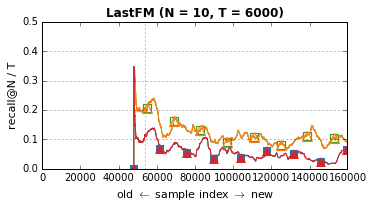

In [179]:
plot('LastFM', exp_lastfm, lastfm_staticMF, lastfm_iMF, lastfm_staticFMs, lastfm_iFMs, N=10, T=6000)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim([0.0, 0.5])

show_results(lastfm_staticMF, lastfm_iMF, lastfm_staticFMs, lastfm_iFMs)

## Plot all

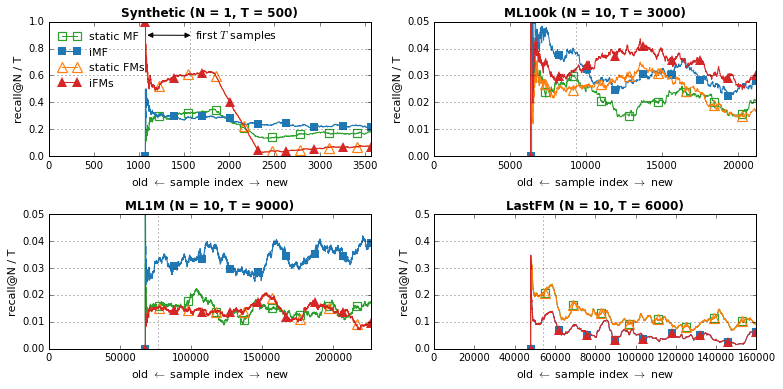

In [210]:
fig = plt.figure()

plt.subplot(221)
plot('Synthetic', exp_click, click_staticMF, click_iMF, click_staticFMs, click_iFMs, N=1, T=500)
plt.yticks([0.0, .2, .4, .6, .8, 1.])
plt.ylim([0.0, 1.])
plt.legend(frameon=False, loc='upper left', fontsize=11)

head = exp_click.data.n_batch_train + exp_click.data.n_batch_test
plt.annotate(r'first $T$ samples', 
             xy=(head, 0.9), xytext=(head + 550, 0.875), 
             size=11, color='k', arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))

plt.subplot(222)
plot('ML100k', exp_ML100k, ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, N=10, T=3000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

plt.subplot(223)
plot('ML1M', exp_ML1M, ML1M_staticMF, ML1M_iMF, ML1M_staticFMs, ML1M_iFMs, N=10, T=9000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])

plt.subplot(224)
plot('LastFM', exp_lastfm, lastfm_staticMF, lastfm_iMF, lastfm_staticFMs, lastfm_iFMs, N=10, T=6000)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim([0.0, 0.5])

fig.set_size_inches((11, 5.5))
plt.tight_layout()

fig.savefig('../../paper/images/recprofile/result.eps')

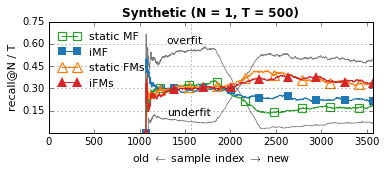

In [177]:
fig = plt.figure()

# also show over/under-fitting cases
overfit = read_result('results/recprofile/click', 'click', 'iFMs', '500', 'overfit')
underfit = read_result('results/recprofile/click', 'click', 'iFMs', '500', 'underfit')

offset = exp_click.data.n_batch_train + exp_click.data.n_batch_test
x = np.arange(exp_click.data.n_sample - offset) + offset
plt.plot(x, overfit, c=colors[14], ls='-', lw=.8)
plt.text(1300, 0.6, 'overfit', color='k', fontsize=11)
plt.plot(x, underfit, c=colors[14], ls='-', lw=.8)
plt.text(1300, 0.12, 'underfit', color='k', fontsize=11)

plot('Synthetic', exp_click, click_staticMF, click_iMF, click_staticFMs, click_iFMs, N=1, T=500)
plt.yticks([.15, .30, .45, .60, .75])
plt.ylim([0.0, .75])
plt.legend(frameon=False, loc='upper left', fontsize=11)

fig.set_size_inches((5.5, 2.5))
plt.tight_layout()

fig.savefig('../../paper/images/recprofile/result_synthetic.eps')

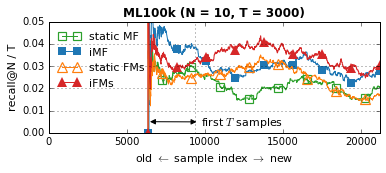

In [154]:
fig = plt.figure()

plot('ML100k', exp_ML100k, ML100k_staticMF, ML100k_iMF, ML100k_staticFMs, ML100k_iFMs, N=10, T=3000)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05])
plt.ylim([0.0, 0.05])
plt.legend(frameon=False, loc='upper left', fontsize=11)

head = exp_ML100k.data.n_batch_train + exp_ML100k.data.n_batch_test
plt.annotate(r'first $T$ samples', 
             xy=(head, 0.005), xytext=(head + 3400, 0.0035), 
             size=11, color='k', arrowprops=dict(color='k', lw=1., arrowstyle='<|-|>'))

fig.set_size_inches((5.5, 2.5))
plt.tight_layout()

fig.savefig('../../paper/images/recprofile/result_ml100k.eps')